## Business Case

For the Chicago Department of Transportation, as a data scientist, my job is to go over the city’s traffic accident reports and create a model that will predict the worst incidences. In doing so, I will find some underlying causes and possible advice for the city.   


For the Chicago Department of Transportation, this data will help reduce the number of traffic accidents that result in injury. 


## Notebook Goals

The goal of this notebook is to take the cleaned data and start to model on it.  
To fit the data into several models, pick the best performing model and keep improving it.

## Preprocessing

In the preprocessing phase I will:
<ul>
<li> Import the cleaned data set.  </li>
<li> One-hot-encode the categorical data  </li>
<li> Run an Anova Statistical Test to single out high p-values </li>
</ul>

### Import data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import plot_confusion_matrix, roc_curve, auc, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor



In [2]:
df = pd.read_csv('data/Cleaned_full_data.csv', index_col=0)
df

,NUM_PASSENGERS,CMRC_VEH_I,VEHICLE_DEFECT,EXCEED_SPEED_LIMIT_I,FIRST_CONTACT_POINT,CITY,SEX,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,POSTED_SPEED_LIMIT,...,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,PRIM_CONTRIBUTORY_CAUSE,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,IS_SEVERE
0,0,N,NO,N,FRONT,CHICAGO,M,D,USAGE UNKNOWN,between 31 mph and 49 mph,...,Y,N,UNABLE TO DETERMINE,N,N,0,12,3,8,0
1,0,N,NO,N,FRONT-LEFT,Out of Town,M,D,SAFETY BELT/HELMENT USED,between 31 mph and 49 mph,...,Y,N,UNABLE TO DETERMINE,N,N,0,12,3,8,0
2,0,N,NO,N,FRONT,Out of Town,M,D,SAFETY BELT/HELMENT USED,30 mph or lower,...,N,N,FOLLOWING TOO CLOSELY,N,N,0,17,6,7,0
3,0,N,NO,N,REAR,Out of Town,M,D,SAFETY BELT/HELMENT USED,30 mph or lower,...,N,N,FOLLOWING TOO CLOSELY,N,N,0,17,6,7,0
4,0,N,NO,N,FRONT,CHICAGO,M,D,USAGE UNKNOWN,30 mph or lower,...,N,N,UNABLE TO DETERMINE,N,N,0,11,4,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794839,1,N,NO,N,SIDE-RIGHT,Out of Town,M,D,USAGE UNKNOWN,30 mph or lower,...,Y,N,DISREGARDING TRAFFIC SIGNALS,N,N,1,23,7,11,1
794840,0,N,NO,N,UNKNOWN,CHICAGO,X,D,USAGE UNKNOWN,30 mph or lower,...,N,N,UNABLE TO DETERMINE,N,N,0,11,7,11,0
794841,0,N,NO,N,UNKNOWN,CHICAGO,X,D,USAGE UNKNOWN,30 mph or lower,...,N,N,UNABLE TO DETERMINE,N,N,0,18,7,11,0
794842,0,N,NO,N,FRONT,CHICAGO,M,D,USAGE UNKNOWN,30 mph or lower,...,N,N,IMPROPER OVERTAKING/PASSING,N,N,0,19,7,11,0


### One-Hot Encode

I am using the pd.get_dummies to one-hot encode my categorical data.  
The idea behind one hot encode is to change all of the categorical data into multiple binary features, so our algorithms can handle the label data more easily.

In [3]:
# creating a list for the categoricals/contious features
categorical_col = list(df.columns)
continous_col = ['NUM_PASSENGERS', 'NUM_UNITS']

# removing all continuous columns from the 
# categorical list
for cont in continous_col:
    if cont in categorical_col:
        categorical_col.remove(cont)
        
# removing other items from the categorical list
categorical_col.remove('IS_SEVERE')

In [4]:
features = df[categorical_col].astype('category')

feats_ohe = pd.get_dummies(features, drop_first = True)

feats_ohe = feats_ohe.astype(int)

In [5]:
df = pd.concat([df['IS_SEVERE'], df[continous_col], feats_ohe], axis=1)
df

,IS_SEVERE,NUM_PASSENGERS,NUM_UNITS,CMRC_VEH_I_Y,VEHICLE_DEFECT_YES,EXCEED_SPEED_LIMIT_I_Y,FIRST_CONTACT_POINT_FRONT-LEFT,FIRST_CONTACT_POINT_FRONT-RIGHT,FIRST_CONTACT_POINT_NONE,FIRST_CONTACT_POINT_OTHER,...,CRASH_MONTH_3,CRASH_MONTH_4,CRASH_MONTH_5,CRASH_MONTH_6,CRASH_MONTH_7,CRASH_MONTH_8,CRASH_MONTH_9,CRASH_MONTH_10,CRASH_MONTH_11,CRASH_MONTH_12
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794839,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
794840,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
794841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
794842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Anova Statistical Test

Anova Statistical Test will test to see if there is any dependence between the variables.  
The test will assign each variable a p-value.  
I will then remove any p-value that scored higher than .05

In [6]:
y = df['IS_SEVERE']
X = df.drop(['IS_SEVERE'], axis=1)

In [7]:
# this creates arrays for f values and p values
f_clf = f_classif(X, y)

#create a series for easy visuals
p_values = pd.Series(f_clf[1])

#adding column names to the p-values
p_values.index = X.columns
p_values.sort_values(ascending=True, inplace=True)
p_values[p_values>0.05]

CRASH_MONTH_5                                                       0.056581
PRIM_CONTRIBUTORY_CAUSE_ROAD CONSTRUCTION/MAINTENANCE               0.083225
CRASH_MONTH_6                                                       0.102595
PRIM_CONTRIBUTORY_CAUSE_RELATED TO BUS STOP                         0.103490
TRAFFICWAY_TYPE_OTHER                                               0.115420
TRAFFICWAY_TYPE_RAMP                                                0.148327
LIGHTING_CONDITION_DUSK                                             0.192904
WORK_ZONE_TYPE_UNKNOWN                                              0.360335
PRIM_CONTRIBUTORY_CAUSE_BICYCLE ADVANCING LEGALLY ON RED LIGHT      0.609199
DRIVERS_LICENSE_CLASS_Other                                         0.783585
PRIM_CONTRIBUTORY_CAUSE_ROAD ENGINEERING/SURFACE/MARKING DEFECTS    0.881998
CRASH_HOUR_19                                                       0.939952
dtype: float64

In [8]:
high_p_values = list(p_values[p_values>0.05].index)

for i in high_p_values:
    X.drop(i, axis=1, inplace=True)

## Train/Test splitting the data

### train/test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

### scale train/test data

In [10]:
scaler = StandardScaler()

scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.fit_transform(X_test)

scaled_df_train = pd.DataFrame(scaled_data_train, columns = X.columns)

## Models

In this phase, I am going to fit the data into four separate models (Logistic Regression, Decision Tree, Random Forest, and K Nearest Neighbors) to see which model can best classify the data for a stronger predictive power.

Some scores that I will be paying attention to help determine the model's performance is:
<ul>
<li> Accuracy: (tp + tn) / (tp+fp+fn+tn)  </li>
<li> Recall: (tp) / (tp+fn)  </li>
<li> AUC: Area Under Curve </li>
</ul>

### Logistic Regression

Logistic Regression is a model that utilize an s-shape curve that helps categorize the data into a binary classification.

In [11]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

logreg.fit(scaled_data_train, y_train)

y_preds = logreg.predict(X_test)

In [12]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.05      0.09    120197
           1       0.25      0.99      0.40     38722

    accuracy                           0.28    158919
   macro avg       0.59      0.52      0.24    158919
weighted avg       0.76      0.28      0.16    158919



In [13]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5168189581185191

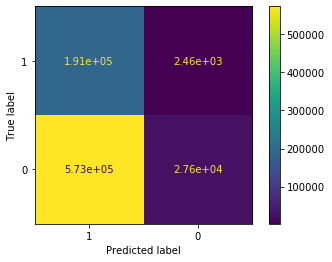

In [14]:
plot_confusion_matrix(logreg, X, y, values_format='.3g', labels = [1,0]);

>accuracy at .28  
>recall at .99  
>auc at .51

Problem: accuracy should never be below .5

### Decision Tree

Decision Tree is another predictive modeling approach that works similar to a flowchart-like structure. The tree is mainly made up of decision nodes(conditionals) and leaves(decision on final outcome).

In [15]:
dtc = DecisionTreeClassifier(criterion='entropy')
dtc.fit(X_train, y_train)

y_preds = dtc.predict(X_test)

In [16]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84    120197
           1       0.51      0.52      0.52     38722

    accuracy                           0.76    158919
   macro avg       0.68      0.68      0.68    158919
weighted avg       0.76      0.76      0.76    158919



In [17]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6795978195656354

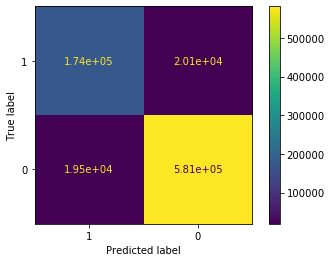

In [18]:
plot_confusion_matrix(dtc, X, y, values_format='.3g', labels = [1,0]);

>accuracy at .76  
>recall at .52  
>auc at .68

### Random Forest

Random Forest builds multiple decision trees can merge them together to get a better performing prediction

In [19]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

y_preds = forest.predict(X_test)

In [20]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86    120197
           1       0.86      0.02      0.04     38722

    accuracy                           0.76    158919
   macro avg       0.81      0.51      0.45    158919
weighted avg       0.79      0.76      0.66    158919



In [21]:
forest.score(X_train, y_train)

0.7606909809399757

In [22]:
forest.score(X_test, y_test)

0.7606516527287486

In [23]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5099654489531082

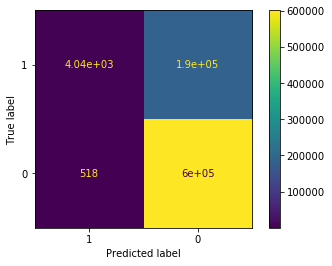

In [24]:
plot_confusion_matrix(forest, X, y, values_format='.3g', labels = [1,0]);

>accuracy at .76  
>recall at .02  
>auc at .50

This model has a very impressive precision score, with the trade off having a terrible recall score  
This model has hardly categorized any data as False Positives.

### K Nearest Neighbors model

K Nearest Neighbors classifies data points based on the distance of the points most similar to it.

In [26]:
#knn = KNeighborsClassifier(metric='euclidean')

#knn.fit(scaled_data_train, y_train)

#y_preds = knn.predict(scaled_data_test)

In [27]:
#print(classification_report(y_test, y_preds))

In [28]:
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_preds)
#roc_auc = auc(false_positive_rate, true_positive_rate)
#roc_auc

## Final Model

Our Decision Tree had the highest accuracy with decent recall and auc scores out of the other baseline models.  
The goal now is to fine tune the decision tree for better accuracy and result scores.

### Grid search

sklearn.model_selection.GridSearchCV will help fine tune this model by running a series of models with all combinations of model parameters. This will help with performance and over-fitting problems.  

Some Decision Tree parameters include:
<ul>
    <li> <u>criterion:</u> The function to measure the quality of a split. </li>
<li> <u>max_depth:</u> The maximum depth of the tree.  </li>
<li> <u>min_samples_split:</u> The minimum number of samples required to split an internal node  </li>
<li> <u>min_samples_leaf:</u> The minimum number of samples required to be at a leaf node. </li>
</ul>
>The Decision Tree documentation can be found here: [scikit-learn DecisionTreeClasasifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [37]:
#dt_param_grid = {
#    'criterion': ['gini', 'entropy'],
#    'max_depth': [None, 2, 3, 4, 5, 6],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
#}

#dt_grid_search = GridSearchCV(dtc, dt_param_grid, cv=3, return_train_score=True)

#dt_grid_search.fit(X_train, y_train)

##Mean training score
#dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

##Mean test score
#dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

#print(f"Mean Training Score: {dt_gs_training_score :.2%}")
#print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
#print("Best Parameter Combination Found During Grid Search:")
#dt_grid_search.best_params_

> Mean Training Score: 80.07%  
> Mean Test Score: 79.27%  
> Best Parameter Combination Found During Grid Search:  
  
> {'criterion': 'gini',  
> 'max_depth': 6,  
> 'min_samples_leaf': 1,  
> 'min_samples_split': 5}  

### Decision Tree

In [30]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=1, min_samples_split=5)
dtc.fit(X_train, y_train)

y_preds = dtc.predict(X_test)

In [32]:
probs = dtc.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = auc(fpr, tpr)
roc_auc

0.7042506257064168

In [33]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87    120197
           1       0.63      0.29      0.40     38722

    accuracy                           0.79    158919
   macro avg       0.72      0.62      0.63    158919
weighted avg       0.76      0.79      0.75    158919



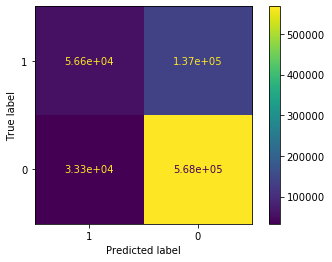

In [34]:
plot_confusion_matrix(dtc, X, y, values_format='.3g', labels = [1,0]);

>accuracy at .79  
>recall at .29  
>auc at .70

Accuracy slightly went up from .76 to .79  
Recall dipped down from .52 to .29  
Auc slightly went up .68 to .70  


### Feature Importances

In [35]:
df_imp = pd.DataFrame(data={'features': X_train.columns, 'importance': dtc.feature_importances_})
df_imp = df_imp.sort_values('importance', ascending=False)
df_imp = df_imp.reset_index()
df_imp.drop('index', axis=1, inplace=True)
df_imp.head(10)

,features,importance
0,INTERSECTION_RELATED_I_Y,0.304137
1,FIRST_CRASH_TYPE_PEDESTRIAN,0.150200
2,FIRST_CRASH_TYPE_REAR END,0.094653
3,FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION,0.087637
4,FIRST_CRASH_TYPE_FIXED OBJECT,0.075494
5,FIRST_CRASH_TYPE_TURNING,0.059226
6,NUM_PASSENGERS,0.052075
7,PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEE...,0.036601
8,FIRST_CRASH_TYPE_PEDALCYCLIST,0.036014
9,FIRST_CONTACT_POINT_OTHER,0.019417


## Recommendations

Intersections, Rear-ending, and failing to reduce speed ranked the highest on the 'feature importance' table. I believe the city of Chicago needs to spend time on researching the effects of adding roundabouts in high traffic intersections. Not only will adding roundabouts lower the chance of a traffic accident becoming severe, but it will also make the driver less dependent on traffic lights and be forced to pay more attention to their surroundings. Another thing that can be done to intersections is that the lanes can be widened to allow for a clear line of sight for drivers turning right on red.


While exploring my data about out-of-town verses in town drivers, I realized that there was a high number of wrecks involving drivers that were not from the city of Chicago. With 23.7 percent of wrecks happening from out-of-town drivers, I believe that this could be due to some of these drivers being from the many suburbs of Chicago. I think the city needs to brainstorm ideas on how this can be improved upon, whether it be making the roadways less complicated or being diligent on better road sign placement throughout the city.
 
The idea of being able to walk safely along the many sidewalks of Chicago as a pedestrian should never be something that becomes an issue. But my data has shown that being a pedestrian was the second most important feature related to severe car accidents in the city. There are many things the city can do to improve upon pedestrian safety and make it easier for drivers to navigate these pedestrians. First, widening driving lanes and adding more right sided shoulders for drivers will give more room for driving errors and increase the time a driver has to react and not hit a pedestrian. Secondly, adding additional sidewalks will make the city more pedestrian friendly. Another would be to increase the distance between the road and the sidewalks, giving both pedestrians and drivers more space to walk or drive safely. Lastly, let's increase the amount of raised pedestrian crosswalks in the city. This will eliminate the possibly of a driver hitting a pedestrian while they are crossing an intersection, thus making our intersections safer as well. 



## Future Work

Most of my future work will be focused on improving my final model by: 
<ul>
<li> Raising ROC curve thresholds as previously mentioned to raise recall score (and lowering the False Negatives)</li>
<li> Running a scatter plot on misclassified data to find a common theme as to why it was misclassified </li>
<li> Looking at feature importance on the chosen model and drop the lowest to speed up future works </li>
</ul>